In [25]:
import itertools
import pathlib
from pathlib import Path
from typing import Optional, List

import yaml
import dataclasses
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.transforms

import lab.metrics
import lab.analytics

sns.set_style("white")
plt.rcParams.update({
    'font.size': 8,
    'axes.titlesize': 8,
    'legend.fontsize': 8,
})

In [29]:
@dataclasses.dataclass
class PlotConfig:
    # Each entry corresponds to an axis with the sub-dictionaries
    # storing mappings of labels to filenames 
    layout: dict
    # The path to store  
    output_files: List[pathlib.Path]
    # Line styles for the various labels
    line_styles: dict = dataclasses.field(default_factory=dict)
    # True if a legend should be added
    with_legend: bool = True
    
    @classmethod
    def from_snakemake(cls):
        return cls(
            layout=snakemake.params["layout"],
            output_files=[Path(p) for path in snakemake.output],
            line_styles=snakemake.params.get("line_styles", {}),
            with_legend=snakemake.params.get("with_legend", False),
        )
    
    def savefig(self, fig, *args, **kwargs):
        for path in self.output_files:
            if path.suffix in (".pdf", ".pgf") and "backend" not in kwargs:
                kwargs["backend"] = "pgf"
                fig.savefig(path, *args, **kwargs)
    

if "snakemake" in globals():
    config = PlotConfig.from_snakemake()
else:
    config = PlotConfig({
            "kFP / FRONT": {
                "defended": f"../../results/ml-eval-brows/defence~front/classifier~kfp/predictions.csv",
                "undefended": f"../../results/ml-eval-brows/defence~undefended/classifier~kfp/predictions.csv"
            }
        },
        [Path("/tmp/plot.png")],
        line_styles={"defended": "-", "undefended": "--"}
    )

In [13]:
def _load_data(inputs):
    return (
        pd.concat([
            pd.read_csv(filename, header=0).assign(title=axes_title, label=label).set_index(["title", "label"], append=True)
            for (axes_title, lines) in inputs.items()
            for (label, filename) in lines.items()
        ])
        .fillna(0)
        .rename(columns=lambda c: int(c) if c != "y_true" else c)
        .astype({"y_true": int})
        .drop(columns=[-1])
    )

data = _load_data(config.layout)
data

,,,y_true,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
,title,label,,,,,,,,,,,,,,,,,,,,,
0,kFP / FRONT,defended,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,kFP / FRONT,defended,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,kFP / FRONT,defended,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,kFP / FRONT,defended,61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,kFP / FRONT,defended,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,kFP / FRONT,undefended,44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1996,kFP / FRONT,undefended,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1997,kFP / FRONT,undefended,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
def precision_recall_curve(df):
    result = lab.analytics.rprecision_recall_curve(df["y_true"], df.drop("y_true", axis=1), ratio=20)
    return pd.DataFrame({"precision": result.precision, "recall": result.recall})

pr_scores = data.groupby(["title", "label"]).apply(lambda x: precision_recall_curve(x))
pr_scores

precision  recall
title       label                          
kFP / FRONT defended   0   0.031571   0.663
                       1   0.152906   0.663
                       2   0.299547   0.529
                       3   1.000000   0.000
            undefended 0   0.046762   0.982
                       1   0.484221   0.982
                       2   0.617237   0.974
                       3   1.000000   0.000

In [22]:
pr_scores.index.unique("title")

Index(['kFP / FRONT'], dtype='object', name='title')

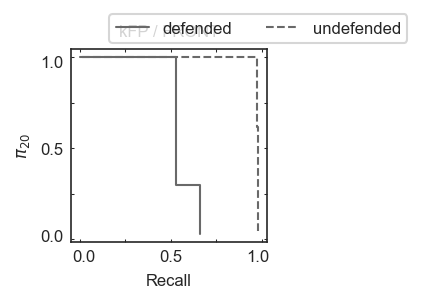

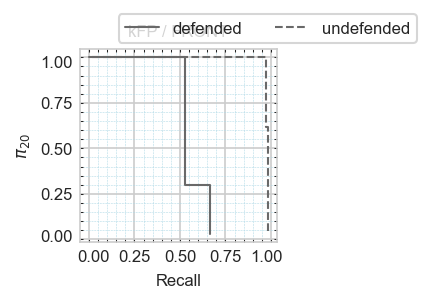

In [31]:
def plot_pr_curves(plot_data, line_styles: dict, with_legend: bool, with_grid: bool=False):
    # Create the axes for the plots
    n_plots = len(pr_scores.index.unique("title"))
    fig, axes_arr = plt.subplots(1, n_plots, figsize=(3.5, 2), sharex=True, sharey=True, dpi=150, squeeze=False)
    # Convert to a 1D array
    axes_arr = axes_arr.ravel()
    
    for (title, data), axes in zip(plot_data.groupby("title"), axes_arr):
        axes.set_title(title)
        
        for (label, data) in data.groupby("label"):
            axes.step(
                "recall", "precision", data=data, label=label, linewidth=1,
                color="dimgrey", linestyle=line_styles.get(label, "-")
            )
        axes.set_xlabel("Recall")
    
        for axis in [axes.xaxis, axes.yaxis]:
            axis.set_major_locator(ticker.FixedLocator([0, .5, 1]))
            axis.set_minor_locator(ticker.MultipleLocator(.25))
            
            if with_grid:
                axis.set_major_locator(ticker.FixedLocator([0, .25, .5, .75, 1]))
                axis.set_minor_locator(ticker.MultipleLocator(.05))
                
        axes.set_aspect("equal")
        axes.margins(0.05)
        axes.tick_params(
            axis='both', which='both', bottom=True, top=True, right=True, left=True,
            direction="in", width=.5, length = 1.5,
        )
        if with_grid:
            axes.grid(True, which="minor", axis="both", color="lightblue", linestyle="--", linewidth=.25)
            
    for axes in axes_arr:
        tick_label = axes.xaxis.get_majorticklabels()[0]
        offset = matplotlib.transforms.ScaledTranslation(2/72, 0, fig.dpi_scale_trans)
        tick_label.set_transform(tick_label.get_transform() + offset)
        
        tick_label = axes.xaxis.get_majorticklabels()[-1]
        offset = matplotlib.transforms.ScaledTranslation(-2/72, 0, fig.dpi_scale_trans)
        tick_label.set_transform(tick_label.get_transform() + offset)
        
    axes = axes_arr[0]
    tick_label = axes.yaxis.get_majorticklabels()[0]
    offset = matplotlib.transforms.ScaledTranslation(0, 2/72, fig.dpi_scale_trans)
    tick_label.set_transform(tick_label.get_transform() + offset)

    tick_label = axes.yaxis.get_majorticklabels()[-1]
    offset = matplotlib.transforms.ScaledTranslation(0, -2/72, fig.dpi_scale_trans)
    tick_label.set_transform(tick_label.get_transform() + offset)
        
    axes_arr[0].set_ylabel("$\pi_{20}$")
    axes_arr[0].yaxis.get_label().set_bbox(dict(boxstyle="square,pad=0", fc="none", ec="none"))
    handles, labels = axes_arr[0].get_legend_handles_labels()
    
    fig.tight_layout(w_pad=.25)
    fig.subplots_adjust(wspace=None, hspace=None)
    if with_legend:
        fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(.97, .85), ncol=3)
    return fig

with sns.axes_style("white"):
    fig = plot_pr_curves(pr_scores, config.line_styles, config.with_legend)
    config.savefig(fig, bbox_inches="tight", dpi=150)
    
with sns.axes_style("whitegrid"):
    fig2 = plot_pr_curves(pr_scores, config.line_styles, config.with_legend, with_grid=True)
    fig2.savefig(config.output_files[0].with_suffix(".grid.pdf"), backend="pgf", bbox_inches="tight")